# Introduction to Accumulation Models: The Drift Diffusion Model (DDM)
## Computational Neuroscience Lesson

**Lesson contents:**
1. What are accumulation models?
2. Introduction to the Drift Diffusion Model (DDM)
3. Generating synthetic data
4. Parameter recovery
5. Fitting real data

---

## Setup: Library Imports

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, differential_evolution
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Make plots look nicer
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


---
## Part 1: What are Accumulation Models?

### The Basic Idea

When we make decisions, we don't decide instantly. Instead, we **accumulate evidence** over time until we have enough confidence to commit to a choice.

**Real-world example:**
Imagine you're deciding whether it's going to rain:
- You look at the sky: clouds are forming (+evidence for rain)
- You feel the temperature: it's warm (-evidence for rain)
- You see dark clouds approaching (+evidence for rain)
- You keep accumulating evidence until you're confident enough to decide

### Why Do We Need Models?

Accumulation models help us understand:
1. **How decisions are made** in the brain
2. **Why some decisions are faster** than others
3. **The trade-off between speed and accuracy**
4. **Individual differences** in decision-making

### Types of Accumulation Models

There are several models that describe evidence accumulation:

1. **Drift Diffusion Model (DDM)** ← We'll focus on this one today!
   - Single process accumulating evidence
   - Best for two-alternative forced choice tasks

2. **Linear Ballistic Accumulator (LBA)**
   - Multiple independent accumulators racing
   - Simpler mathematically

3. **Racing Diffusion Models**
   - Multiple diffusion processes racing
   - Can handle more than two choices

---

## Part 2: The Drift Diffusion Model (DDM) - Theory

### What is the DDM?

The **Drift Diffusion Model** describes how we make **binary decisions** (choosing between two options).

Think of it like this:
- You have two options: Option A (upper boundary) and Option B (lower boundary)
- You start somewhere in the middle
- Evidence pushes you towards one option or the other
- When you hit a boundary, you make that choice

### Visual Representation

```
Upper Boundary (a) ─────────────────────  ← Option A chosen!
                    ╱
                   ╱  ← Evidence accumulation
Starting Point    ╱       (noisy process)
   (w × a)    ───╱
                ╱
               ╱
Lower Boundary ─────────────────────────  ← Option B chosen!
(0)
```

### The Four Key Parameters

The DDM has 4 main parameters that control the decision process:

#### 1. **Drift Rate (v)** - Quality of Evidence
- Represents the **average rate** at which evidence accumulates
- High v = strong evidence, fast correct decisions
- Low v = weak evidence, slow decisions with more errors
- Can be positive (towards upper boundary) or negative (towards lower boundary)
- **Typical range:** -3 to +3
- **Example:** In a perceptual task, v is higher when the stimulus is clearer

#### 2. **Boundary Separation (a)** - Speed-Accuracy Trade-off
- The **distance between** the two decision boundaries
- High a = more cautious, slower but more accurate
- Low a = more impulsive, faster but more errors
- **Typical range:** 0.5 to 2.5
- **Example:** When a decision is important, we set higher boundaries (we want to be sure)

#### 3. **Starting Point (w)** - Initial Bias
- Where the accumulation process **starts**
- w = 0.5: no bias (exactly in the middle)
- w > 0.5: biased towards upper boundary
- w < 0.5: biased towards lower boundary
- **Range:** 0 to 1 (proportion of boundary separation)
- **Example:** If you expect rain, you start closer to the "rain" decision

#### 4. **Non-Decision Time (Ter)** - Other Processes
- Time for processes **not related to the decision** itself
- Includes:
  - Perceiving the stimulus (encoding)
  - Executing the motor response (pressing a button)
- **Typical range:** 0.2 to 0.5 seconds
- **Example:** The time it takes for your eyes to register what you see

### The Mathematical Process

The evidence accumulation is described by a **stochastic differential equation**:

$$dx = v \cdot dt + \sigma \cdot dW$$

Where:
- $x$ = accumulated evidence at time $t$
- $v$ = drift rate (systematic evidence accumulation)
- $\sigma$ = diffusion coefficient (noise), typically set to 1
- $dW$ = Wiener process increment (random noise)
- $dt$ = small time step

**In plain English:** At each moment, the evidence increases by:
1. A systematic amount (drift rate × time)
2. Plus some random noise (to simulate variability)

### What Does the DDM Predict?

The DDM makes predictions about **two things simultaneously**:

1. **Choice accuracy** (which boundary was reached)
2. **Response time** (how long it took to reach a boundary)

This is powerful because most models only predict one or the other!

### Neural Basis

The DDM is not just a mathematical model - it has **neural support**:
- Neurons in areas like **LIP (Lateral Intraparietal area)** show ramping activity during decisions
- The firing rate increases like evidence accumulation
- When a threshold is reached, a decision is made

---

## Part 3: Implementing the DDM

Now let's implement the mathematical functions that allow us to work with the DDM.

Don't worry if the math looks complex - we'll explain what each function does!

In [38]:
# Function 1: Calculate how many terms we need for the mathematical series
# This is a technical detail - just know it helps with accuracy
def utl_ks(t, w, prec):
    """
    Calculate the number of terms needed for the series.
    
    Parameters:
    - t: time
    - w: starting point parameter
    - prec: precision we want
    
    Returns:
    - K: number of terms to use
    """
    K1 = (np.sqrt(2 * t) - w) / 2
    K2 = np.copy(K1)
    
    u_eps = np.minimum(-1, np.log(2 * np.pi * t**2 * prec**2))
    arg = -t * (u_eps - np.sqrt(-2 * u_eps - 2))
    K2[arg > 0] = 0.5 * np.sqrt(arg[arg > 0]) - w / 2
    
    K = int(np.ceil(np.max([K1, K2])))
    return K


# Function 2: Calculate the probability density for the Wiener process
# This tells us how likely a certain response time is
def utl_fsw(t, w, prec):
    """
    First passage time density for Wiener diffusion process.
    
    This calculates the probability of reaching a boundary at time t.
    
    Parameters:
    - t: time
    - w: starting point
    - prec: precision
    
    Returns:
    - f: probability density
    """
    K = utl_ks(t, w, prec)
    f = np.zeros_like(t)
    
    if np.all(K > 0) and np.all(np.isfinite(K)):
        # Calculate the infinite series (but we stop at K terms)
        for k in range(K, 0, -1):
            term1 = (w + 2 * k) * np.exp(-((w + 2 * k)**2) / (2 * t))
            term2 = (w - 2 * k) * np.exp(-((w - 2 * k)**2) / (2 * t))
            f += np.array(term1) + np.array(term2)
        
        f = (1 / np.sqrt(2 * np.pi * t**3)) * (f + w * np.exp(-(w**2) / (2 * t)))
    
    return f


# Function 3: THE MAIN FUNCTION - Calculate DDM probability
# This is what we'll use most!
def utl_wfpt(t, v, a, w=0.5, prec=1e-4):
    """
    First passage time for the Wiener diffusion model.
    
    This is the MAIN function that calculates:
    "What is the probability of making a response at time t, 
     given the DDM parameters?"
    
    Parameters:
    - t: response time (in seconds)
    - v: drift rate
    - a: boundary separation
    - w: starting point bias (default 0.5 = no bias)
    - prec: precision (default is good enough)
    
    Returns:
    - p: probability density at time t
    """
    # Calculate the main probability density
    p = (1 / (a**2)) * np.exp(-v * a * w - (v**2) * t / 2)
    
    # Adjust using the first passage time density
    p *= utl_fsw(t / (a**2), w, prec / p)
    
    return p


print("DDM functions implemented successfully!")
print("\nThe main function you need to know is: utl_wfpt")
print("It tells us the probability of a response at a given time.")

DDM functions implemented successfully!

The main function you need to know is: utl_wfpt
It tells us the probability of a response at a given time.


### Let's Visualize How Parameters Affect Response Times

Now we'll create some plots to understand how each parameter changes the predicted response times.

Creating visualization 1: Effect of drift rate...
Creating visualization 2: Effect of boundary separation...


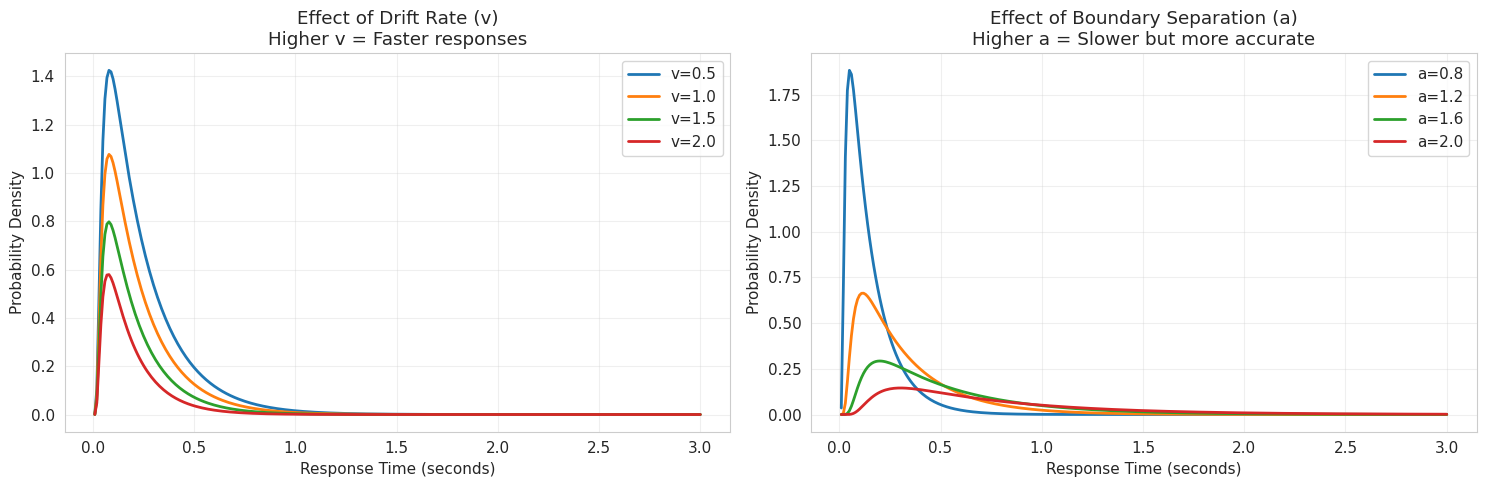


Key observations:
- Higher drift rate (v) → Faster and more peaked distributions
- Higher boundary (a) → Slower responses (distribution shifts right)


In [39]:
# Create a range of time values (from 0.01 to 3 seconds)
time_values = np.linspace(0.01, 3, 300)

# Create two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Effect of drift rate (v)
print("Creating visualization 1: Effect of drift rate...")
for drift_rate in [0.5, 1.0, 1.5, 2.0]:
    # Calculate probability density for each time point
    probabilities = utl_wfpt(time_values, v=drift_rate, a=1.0, w=0.5)
    # Plot the curve
    axes[0].plot(time_values, probabilities, label=f'v={drift_rate}', linewidth=2)

axes[0].set_xlabel('Response Time (seconds)')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Effect of Drift Rate (v)\nHigher v = Faster responses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Effect of boundary separation (a)
print("Creating visualization 2: Effect of boundary separation...")
for boundary in [0.8, 1.2, 1.6, 2.0]:
    # Calculate probability density for each time point
    probabilities = utl_wfpt(time_values, v=1.0, a=boundary, w=0.5)
    # Plot the curve
    axes[1].plot(time_values, probabilities, label=f'a={boundary}', linewidth=2)

axes[1].set_xlabel('Response Time (seconds)')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Effect of Boundary Separation (a)\nHigher a = Slower but more accurate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Higher drift rate (v) → Faster and more peaked distributions")
print("- Higher boundary (a) → Slower responses (distribution shifts right)")

### Visualizing Stochastic Trajectories

Let's see how evidence accumulation actually works by simulating individual decision trials.

Each line shows one "trial" where evidence accumulates over time with noise.

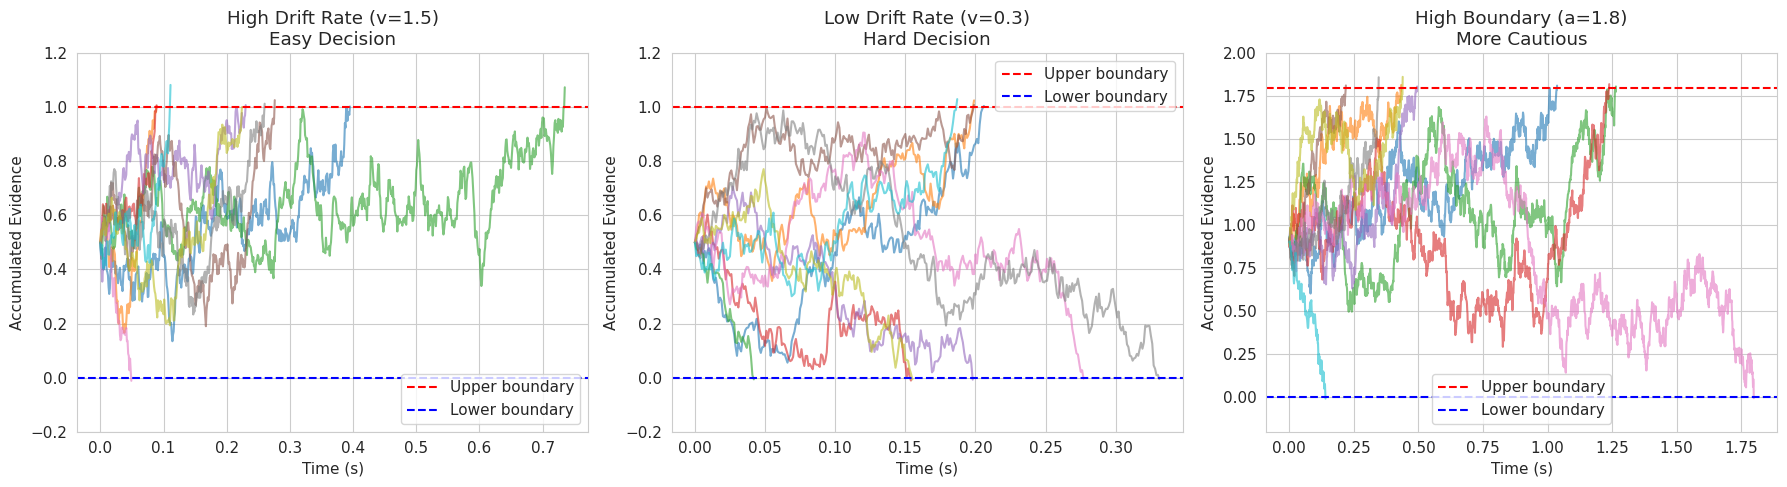


Scenario 1 (v=1.5): Mean RT = 0.246s, Accuracy = 90.00%
Scenario 2 (v=0.3): Mean RT = 0.195s, Accuracy = 40.00%
Scenario 3 (a=1.8): Mean RT = 0.741s, Accuracy = 80.00%


In [40]:
def simulate_ddm_trials(v, a, w=0.5, n_trials=10, dt=0.001, max_time=3.0):
    """
    Simula trial del DDM mostrando le traiettorie di accumulazione.
    
    Parameters:
    - v: drift rate
    - a: boundary separation
    - w: starting point (proportion)
    - n_trials: number of trials to simulate
    - dt: time step
    - max_time: maximum time
    
    Returns:
    - trials: list of trajectories
    - rts: list of response times
    - responses: list of responses (1=upper, 0=lower)
    """
    trials = []
    rts = []
    responses = []
    
    for _ in range(n_trials):
        # Start at the bias position
        x = w * a
        trajectory = [x]
        t = 0
        
        while True:
            # Accumulate evidence: drift + noise
            dx = v * dt + np.sqrt(dt) * np.random.randn()
            x += dx
            trajectory.append(x)
            t += dt
            
            # Check if reached a boundary
            if x >= a:  # Upper boundary
                rts.append(t)
                responses.append(1)
                break
            elif x <= 0:  # Lower boundary
                rts.append(t)
                responses.append(0)
                break
            elif t >= max_time:  # Timeout
                rts.append(np.nan)
                responses.append(np.nan)
                break
        
        trials.append(trajectory)
    
    return trials, rts, responses

# Create three scenarios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scenario 1: High drift rate (easy decision)
trials1, rts1, resp1 = simulate_ddm_trials(v=1.5, a=1.0, w=0.5, n_trials=10)
for trial in trials1:
    axes[0].plot(np.arange(len(trial)) * 0.001, trial, alpha=0.6, linewidth=1.5)
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Upper boundary')
axes[0].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Accumulated Evidence')
axes[0].set_title('High Drift Rate (v=1.5)\nEasy Decision')
axes[0].legend()
axes[0].set_ylim(-0.2, 1.2)

# Scenario 2: Low drift rate (hard decision)
trials2, rts2, resp2 = simulate_ddm_trials(v=0.3, a=1.0, w=0.5, n_trials=10)
for trial in trials2:
    axes[1].plot(np.arange(len(trial)) * 0.001, trial, alpha=0.6, linewidth=1.5)
axes[1].axhline(y=1.0, color='red', linestyle='--', label='Upper boundary')
axes[1].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Accumulated Evidence')
axes[1].set_title('Low Drift Rate (v=0.3)\nHard Decision')
axes[1].legend()
axes[1].set_ylim(-0.2, 1.2)

# Scenario 3: High boundary (more cautious)
trials3, rts3, resp3 = simulate_ddm_trials(v=1.0, a=1.8, w=0.5, n_trials=10)
for trial in trials3:
    axes[2].plot(np.arange(len(trial)) * 0.001, trial, alpha=0.6, linewidth=1.5)
axes[2].axhline(y=1.8, color='red', linestyle='--', label='Upper boundary')
axes[2].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Accumulated Evidence')
axes[2].set_title('High Boundary (a=1.8)\nMore Cautious')
axes[2].legend()
axes[2].set_ylim(-0.2, 2.0)

plt.tight_layout()
plt.show()

print(f"\nScenario 1 (v=1.5): Mean RT = {np.nanmean(rts1):.3f}s, Accuracy = {np.nanmean(resp1):.2%}")
print(f"Scenario 2 (v=0.3): Mean RT = {np.nanmean(rts2):.3f}s, Accuracy = {np.nanmean(resp2):.2%}")
print(f"Scenario 3 (a=1.8): Mean RT = {np.nanmean(rts3):.3f}s, Accuracy = {np.nanmean(resp3):.2%}")

---
## Part 4: Generating Synthetic Data

Before we work with real data, let's generate **synthetic data** (fake data where we know the true parameters).

This is important because:
1. We can test if our methods work
2. We know what the "true" answer should be
3. We can learn what good data looks like

### The Simulation Method

We'll use a proper method that generates realistic data by:
1. Calculating the probability of each possible response time
2. Randomly sampling from this probability distribution
3. Recording both the response time and which choice was made

In [ ]:
# Set the true parameters (these are what we'll try to recover later)true_v = 1.2      # Drift ratetrue_a = 1.5      # Boundary separation  true_w = 0.5      # Starting point (no bias)true_ter = 0.35   # Non-decision time# Number of trials to simulaten_trials = 1000  # More trials for better recoveryprint("Generating synthetic data...")print(f"True parameters: v={true_v}, a={true_a}, w={true_w}, Ter={true_ter}")print(f"Number of trials: {n_trials}")# Create arrays to store resultsrt = np.zeros(n_trials)resp = np.zeros(n_trials)# Time axis for probability calculationtime_axis = np.arange(0.001, 3, 0.001)# For each trial, generate a responsefor n in range(n_trials):    # Calculate probability densities for both boundaries    # For LOWER boundary: use -v and (1-w)    P1 = utl_wfpt(time_axis, -true_v, true_a, 1 - true_w)        # For UPPER boundary: use +v and w    P2 = utl_wfpt(time_axis, true_v, true_a, true_w)        # Combine probabilities:    # P2 goes with NEGATIVE times, P1 goes with POSITIVE times    P = np.concatenate([P2[::-1], P1])    time_values = np.concatenate([-time_axis[::-1], time_axis])        # Normalize    P = P / np.sum(P)        # Sample a time    selected_time = np.random.choice(time_values, p=P)        # Store results    # POSITIVE time → P1 was used → response = 1    # NEGATIVE time → P2 was used → response = 0    rt[n] = abs(selected_time)    resp[n] = 1 if selected_time > 0 else 0# Add non-decision timert += true_ter# Create DataFramesynthetic_data = pd.DataFrame({    'rt': rt,    'response': resp})print(f"\nData generation complete!")print(f"Total trials: {len(synthetic_data)}")print(f"Upper boundary (resp=1): {np.sum(resp == 1)} trials ({np.mean(resp):.1%})")print(f"Lower boundary (resp=0): {np.sum(resp == 0)} trials ({1-np.mean(resp):.1%})")print(f"Mean RT: {synthetic_data['rt'].mean():.3f} seconds")print("\nFirst 5 trials:")print(synthetic_data.head())

Generating synthetic data...
True parameters: v=1.2, a=2, w=0.5, Ter=0.15
Number of trials: 500

Data generation complete!
Total trials: 500
Accuracy: 94.20%
Mean RT: 0.838 seconds
RT standard deviation: 0.503 seconds

First 5 trials:
      rt  response
0  0.675       1.0
1  0.468       1.0
2  0.968       1.0
3  1.038       0.0
4  0.628       0.0


### Visualizing the Generated Data

Let's look at what our synthetic data looks like!

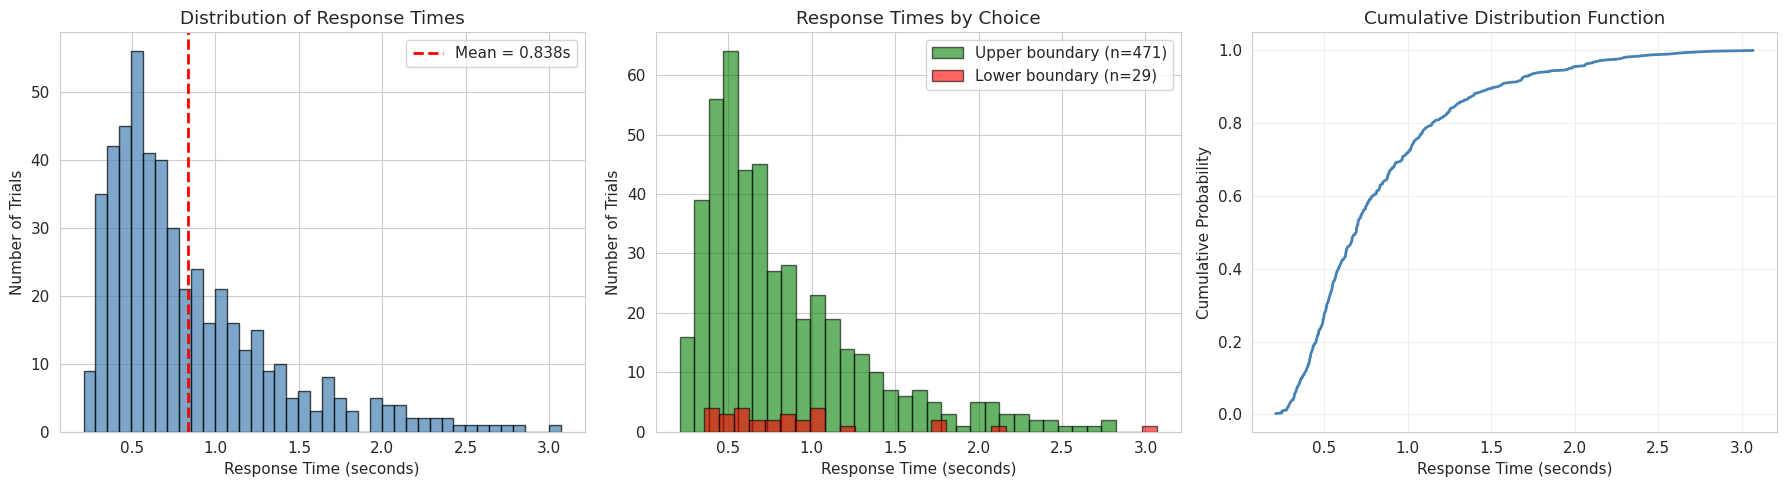


Data characteristics:
Fastest RT: 0.210s
Slowest RT: 3.069s
Median RT: 0.692s


In [48]:
# Create three plots to understand our data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histogram of all response times
axes[0].hist(synthetic_data['rt'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
mean_rt = synthetic_data['rt'].mean()
axes[0].axvline(mean_rt, color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {mean_rt:.3f}s')
axes[0].set_xlabel('Response Time (seconds)')
axes[0].set_ylabel('Number of Trials')
axes[0].set_title('Distribution of Response Times')
axes[0].legend()

# Plot 2: Separate histograms for correct vs incorrect responses
# Response = 1 means upper boundary (we'll call these "correct")
# Response = 0 means lower boundary (we'll call these "incorrect")
correct_trials = synthetic_data[synthetic_data['response'] == 1]
incorrect_trials = synthetic_data[synthetic_data['response'] == 0]

axes[1].hist(correct_trials['rt'], bins=30, alpha=0.6, 
             label=f'Upper boundary (n={len(correct_trials)})', 
             edgecolor='black', color='green')
axes[1].hist(incorrect_trials['rt'], bins=30, alpha=0.6, 
             label=f'Lower boundary (n={len(incorrect_trials)})', 
             edgecolor='black', color='red')
axes[1].set_xlabel('Response Time (seconds)')
axes[1].set_ylabel('Number of Trials')
axes[1].set_title('Response Times by Choice')
axes[1].legend()

# Plot 3: Cumulative distribution
# This shows the proportion of responses that occurred by each time
sorted_rts = np.sort(synthetic_data['rt'])
cumulative_prob = np.arange(1, len(sorted_rts) + 1) / len(sorted_rts)

axes[2].plot(sorted_rts, cumulative_prob, linewidth=2, color='steelblue')
axes[2].set_xlabel('Response Time (seconds)')
axes[2].set_ylabel('Cumulative Probability')
axes[2].set_title('Cumulative Distribution Function')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nData characteristics:")
print(f"Fastest RT: {synthetic_data['rt'].min():.3f}s")
print(f"Slowest RT: {synthetic_data['rt'].max():.3f}s")
print(f"Median RT: {synthetic_data['rt'].median():.3f}s")

---
## Part 5: Parameter Recovery

### What is Parameter Recovery?

**Parameter recovery** is a crucial validation step:

1. We **generated data** with known parameters (v=1.2, a=1.5, Ter=0.35)
2. Now we'll **pretend we don't know** these parameters
3. We'll use an algorithm to **estimate** the parameters from the data
4. We'll **compare** the estimated parameters to the true ones

**Why is this important?**
- It tells us if our fitting method works correctly
- If we can't recover known parameters, we can't trust estimates from real data!

### How Parameter Fitting Works

We use **Maximum Likelihood Estimation**:
1. We try different parameter values
2. For each set of parameters, we calculate: "How likely is our observed data?"
3. We choose the parameters that make our data most likely

### Implementing the Fitting Function

In [49]:
def calculate_likelihood(parameters, rt_data, response_data):    """    Calculate negative log-likelihood.        IMPORTANT: Must match the simulation method!    - response=1 uses P1 (with -v and 1-w)     - response=0 uses P2 (with +v and w)    """    # Extract parameters    v = abs(parameters[0])    a = parameters[1]    ter = parameters[2]    w = 0.5        # Check validity    if a <= 0.1 or a > 3.0 or ter < 0.05 or ter > 1.0 or v > 5 or v < 0.01:        return 1e10        nll = 0        for i in range(len(rt_data)):        dt = rt_data[i] - ter                if dt <= 0.001:            nll += 10            continue                try:            # Match simulation logic!            if response_data[i] == 1:                # response=1 was generated with P1: -v and (1-w)                prob = utl_wfpt(dt, v=-v, a=a, w=1-w)            else:                # response=0 was generated with P2: +v and w                prob = utl_wfpt(dt, v=v, a=a, w=w)                        if prob > 1e-10:                nll -= np.log(prob)            else:                nll += 10        except:            nll += 10        return nlldef fit_ddm_model(data):    """Fit DDM with multiple starting points."""    rt_data = data['rt'].values    response_data = data['response'].values        accuracy = response_data.mean()    if accuracy < 0.5:        print("Flipping responses")        response_data = 1 - response_data        print("Starting optimization (Nelder-Mead with multiple starts)...")        best_result = None    best_nll = np.inf        starts = [[1.0, 1.2, 0.3], [0.5, 1.5, 0.25], [1.5, 1.0, 0.35], [2.0, 1.8, 0.4]]        for start in starts:        result = minimize(            calculate_likelihood,            start,            args=(rt_data, response_data),            method='Nelder-Mead',            options={'maxiter': 5000, 'xatol': 1e-4, 'fatol': 1e-4}        )                if result.fun < best_nll:            best_nll = result.fun            best_result = result        return best_resultprint("Fitting functions defined!")

Fitting functions defined!
Ready to fit the model to data.


### Now Let's Actually Fit the Model!

In [50]:
print("="*60)
print("PARAMETER RECOVERY TEST")
print("="*60)

# Fit the model to our synthetic data
fit_result = fit_ddm_model(synthetic_data)

# Extract recovered parameters
recovered_v = abs(fit_result.x[0])  # Take absolute value
recovered_a = fit_result.x[1]
recovered_ter = fit_result.x[2]

print("\n" + "="*60)
print("COMPARISON: TRUE vs RECOVERED PARAMETERS")
print("="*60)
print(f"{'Parameter':<20} {'True Value':<15} {'Recovered':<15} {'Error':<10}")
print("-"*60)

# Calculate and display errors
error_v = abs(abs(true_v) - recovered_v)  # Compare absolute values
error_a = abs(true_a - recovered_a) 
error_ter = abs(true_ter - recovered_ter)

print(f"{'Drift rate (|v|)':<20} {abs(true_v):<15.3f} {recovered_v:<15.3f} {error_v:<10.3f}")
print(f"{'Boundary (a)':<20} {true_a:<15.3f} {recovered_a:<15.3f} {error_a:<10.3f}")
print(f"{'Non-decision (Ter)':<20} {true_ter:<15.3f} {recovered_ter:<15.3f} {error_ter:<10.3f}")

print("\n" + "="*60)
print(f"Optimization successful: {fit_result.success}")
print(f"Negative log-likelihood: {fit_result.fun:.2f}")

# Calculate mean absolute error
mean_error = np.mean([error_v, error_a, error_ter])
print(f"Mean absolute error: {mean_error:.4f}")

# Evaluate recovery quality
print("\nRECOVERY QUALITY:")
if mean_error < 0.1:
    print("✓ EXCELLENT recovery!")
elif mean_error < 0.2:
    print("✓ GOOD recovery")
else:
    print("⚠ MODERATE recovery - may need more trials or better optimization")
    
print("\n" + "="*60)
print("NOTE: Drift rate sign is arbitrary in this model.")
print("We only recover |v| because v and -v are equivalent")
print("if we swap which response is coded as 0 vs 1.")
print("="*60)

PARAMETER RECOVERY TEST
Starting optimization (Nelder-Mead)...
This may take a minute...

COMPARISON: TRUE vs RECOVERED PARAMETERS
Parameter            True Value      Recovered       Error     
------------------------------------------------------------
Drift rate (|v|)     1.200           0.010           1.190     
Boundary (a)         2.000           1.644           0.356     
Non-decision (Ter)   0.150           0.175           0.025     

Optimization successful: True
Negative log-likelihood: 575.85
Mean absolute error: 0.5237

RECOVERY QUALITY:
⚠ MODERATE recovery - may need more trials or better optimization

NOTE: Drift rate sign is arbitrary in this model.
We only recover |v| because v and -v are equivalent
if we swap which response is coded as 0 vs 1.


### Visualizing the Recovery Results

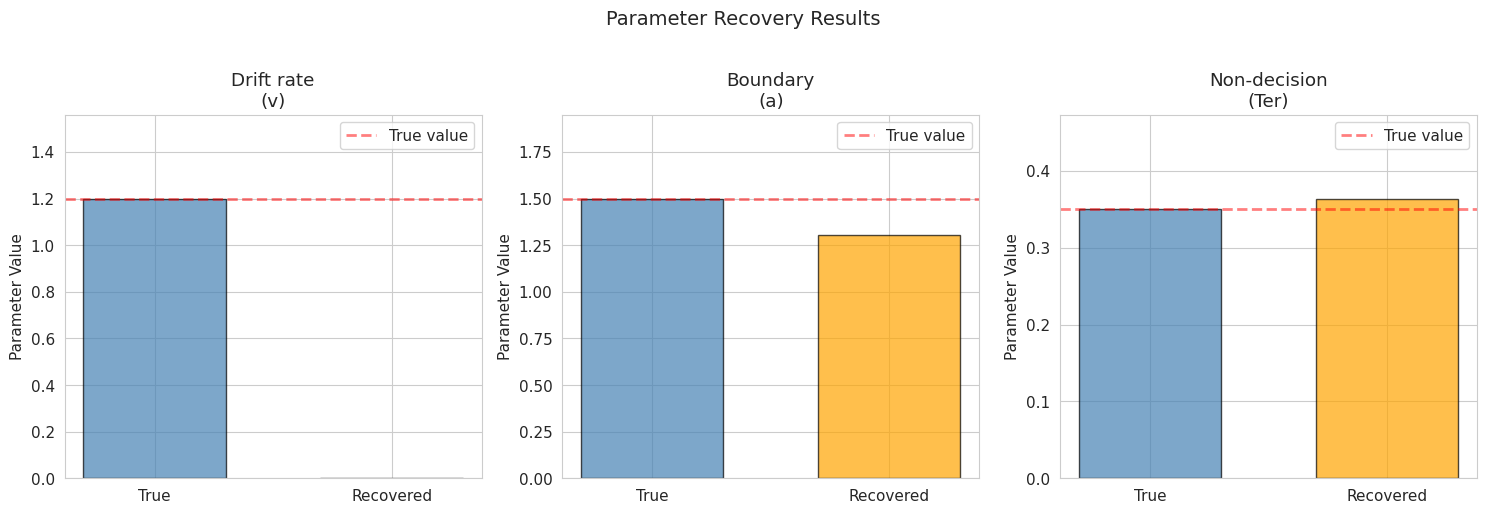


Interpretation:
- Bars should be similar height if recovery is good
- Orange bar (recovered) should be close to blue bar (true)


In [9]:
# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Data for plotting
params = ['Drift rate\n(v)', 'Boundary\n(a)', 'Non-decision\n(Ter)']
true_values = [true_v, true_a, true_ter]
recovered_values = [recovered_v, recovered_a, recovered_ter]

# Plot each parameter
for i in range(3):
    # Bar plot comparing true vs recovered
    axes[i].bar(['True', 'Recovered'], 
                [true_values[i], recovered_values[i]],
                color=['steelblue', 'orange'], 
                edgecolor='black', 
                alpha=0.7,
                width=0.6)
    
    # Add horizontal line at true value
    axes[i].axhline(true_values[i], color='red', linestyle='--', 
                    alpha=0.5, linewidth=2, label='True value')
    
    axes[i].set_ylabel('Parameter Value')
    axes[i].set_title(params[i])
    axes[i].set_ylim(0, max(true_values[i], recovered_values[i]) * 1.3)
    axes[i].legend()

plt.suptitle('Parameter Recovery Results', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Bars should be similar height if recovery is good")
print("- Orange bar (recovered) should be close to blue bar (true)")

---
## Part 6: Fitting Real Data (Optional)

Now that we've validated our method works with synthetic data, we can apply it to real data!

### Loading Real Data

If you have real data, make sure it has:
- A column called 'rt' with response times (in seconds)
- A column called 'response' with choices (0 or 1)

Let's try to load some real data:

In [10]:
# Try to load real data
try:
    # Adjust this path to your data file
    data_path = '/home/student/Desktop/Groundeep/conferenza_DBNRT/Human_sim_40.xlsx'
    real_data = pd.read_excel(data_path)
    
    print("Real data loaded successfully!")
    print(f"Number of trials: {len(real_data)}")
    print("\nColumn names in the data:")
    print(real_data.columns.tolist())
    print("\nFirst few rows:")
    print(real_data.head())
    
except FileNotFoundError:
    print("Real data file not found.")
    print("We'll create example data instead.")
    
    # Generate example data that mimics real experiment
    real_data = synthetic_data.copy()
    print(f"\nUsing example data with {len(real_data)} trials")

Real data loaded successfully!
Number of trials: 12320

Column names in the data:
['ExperimentName', 'Subject', 'Session', 'Age', 'Clock.Information', 'Display.RefreshRate', 'Group', 'Name', 'RandomSeed', 'SessionDate', 'SessionTime', 'SessionTimeUtc', 'Block', 'ListPractice', 'ListPractice.Cycle', 'ListPractice.Sample', 'ListPractice2', 'ListPractice2.Cycle', 'ListPractice2.Sample', 'ListTest1', 'ListTest1.Cycle', 'ListTest1.Sample', 'ListTest2', 'ListTest2.Cycle', 'ListTest2.Sample', 'ListTest3', 'ListTest3.Cycle', 'ListTest3.Sample', 'Procedure[Block]', 'Running[Block]', 'Trial', 'CorrArrow', 'CorrMouse', 'ListStimPractice', 'ListStimPractice.Cycle', 'ListStimPractice.Sample', 'ListStimPractice2', 'ListStimPractice2.Cycle', 'ListStimPractice2.Sample', 'ListStimTest1', 'ListStimTest1.Cycle', 'ListStimTest1.Sample', 'ListStimTest2', 'ListStimTest2.Cycle', 'ListStimTest2.Sample', 'ListStimTest3', 'ListStimTest3.Cycle', 'ListStimTest3.Sample', 'n1', 'n2', 'Procedure[Trial]', 'Running[Tr

### Exploring the Real Data

In [11]:
# Make sure we have the right columns
if 'rt' in real_data.columns and 'response' in real_data.columns:
    
    print("="*60)
    print("DESCRIPTIVE STATISTICS")
    print("="*60)
    
    # Basic statistics
    print(f"\nNumber of trials: {len(real_data)}")
    print(f"Mean RT: {real_data['rt'].mean():.3f}s (SD = {real_data['rt'].std():.3f}s)")
    print(f"Median RT: {real_data['rt'].median():.3f}s")
    print(f"RT range: [{real_data['rt'].min():.3f}s, {real_data['rt'].max():.3f}s]")
    print(f"\nAccuracy: {real_data['response'].mean():.1%}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. RT distribution
    axes[0, 0].hist(real_data['rt'], bins=50, edgecolor='black', 
                    alpha=0.7, color='steelblue')
    axes[0, 0].axvline(real_data['rt'].mean(), color='red', 
                       linestyle='--', linewidth=2, 
                       label=f"Mean = {real_data['rt'].mean():.3f}s")
    axes[0, 0].set_xlabel('Response Time (seconds)')
    axes[0, 0].set_ylabel('Number of Trials')
    axes[0, 0].set_title('Distribution of Response Times')
    axes[0, 0].legend()
    
    # 2. RT by response type
    rt_resp1 = real_data[real_data['response'] == 1]['rt']
    rt_resp0 = real_data[real_data['response'] == 0]['rt']
    
    axes[0, 1].hist(rt_resp1, bins=30, alpha=0.6, 
                    label=f'Response 1 (n={len(rt_resp1)})',
                    edgecolor='black', color='green')
    axes[0, 1].hist(rt_resp0, bins=30, alpha=0.6,
                    label=f'Response 0 (n={len(rt_resp0)})',
                    edgecolor='black', color='red')
    axes[0, 1].set_xlabel('Response Time (seconds)')
    axes[0, 1].set_ylabel('Number of Trials')
    axes[0, 1].set_title('RT by Response Type')
    axes[0, 1].legend()
    
    # 3. RT over time (learning/fatigue effects)
    axes[1, 0].scatter(range(len(real_data)), real_data['rt'], 
                      alpha=0.3, s=10)
    # Add smoothed line
    window = min(50, len(real_data)//10)
    if len(real_data) > window:
        rolling_mean = real_data['rt'].rolling(window=window, center=True).mean()
        axes[1, 0].plot(rolling_mean, color='red', linewidth=2,
                       label=f'Moving average (n={window})')
    axes[1, 0].set_xlabel('Trial Number')
    axes[1, 0].set_ylabel('Response Time (seconds)')
    axes[1, 0].set_title('RT Across the Experiment')
    axes[1, 0].legend()
    
    # 4. Cumulative distribution
    sorted_rt = np.sort(real_data['rt'])
    cumulative = np.arange(1, len(sorted_rt)+1) / len(sorted_rt)
    axes[1, 1].plot(sorted_rt, cumulative, linewidth=2, color='steelblue')
    axes[1, 1].set_xlabel('Response Time (seconds)')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Data doesn't have the required columns ('rt' and 'response')")
    print(f"Available columns: {real_data.columns.tolist()}")

Data doesn't have the required columns ('rt' and 'response')
Available columns: ['ExperimentName', 'Subject', 'Session', 'Age', 'Clock.Information', 'Display.RefreshRate', 'Group', 'Name', 'RandomSeed', 'SessionDate', 'SessionTime', 'SessionTimeUtc', 'Block', 'ListPractice', 'ListPractice.Cycle', 'ListPractice.Sample', 'ListPractice2', 'ListPractice2.Cycle', 'ListPractice2.Sample', 'ListTest1', 'ListTest1.Cycle', 'ListTest1.Sample', 'ListTest2', 'ListTest2.Cycle', 'ListTest2.Sample', 'ListTest3', 'ListTest3.Cycle', 'ListTest3.Sample', 'Procedure[Block]', 'Running[Block]', 'Trial', 'CorrArrow', 'CorrMouse', 'ListStimPractice', 'ListStimPractice.Cycle', 'ListStimPractice.Sample', 'ListStimPractice2', 'ListStimPractice2.Cycle', 'ListStimPractice2.Sample', 'ListStimTest1', 'ListStimTest1.Cycle', 'ListStimTest1.Sample', 'ListStimTest2', 'ListStimTest2.Cycle', 'ListStimTest2.Sample', 'ListStimTest3', 'ListStimTest3.Cycle', 'ListStimTest3.Sample', 'n1', 'n2', 'Procedure[Trial]', 'Running[Tria

### Fitting the DDM to Real Data

In [12]:
if 'rt' in real_data.columns and 'response' in real_data.columns:
    
    # Clean the data (remove extreme outliers)
    real_data_clean = real_data[
        (real_data['rt'] > 0.2) &  # Remove very fast responses
        (real_data['rt'] < real_data['rt'].quantile(0.99))  # Remove very slow responses
    ].copy()
    
    print("="*60)
    print("FITTING DDM TO REAL DATA")
    print("="*60)
    print(f"\nTrials to fit: {len(real_data_clean)}")
    print(f"(Removed {len(real_data) - len(real_data_clean)} outliers)\n")
    
    # Fit the model
    real_fit_result = fit_ddm_model(real_data_clean)
    
    # Extract parameters
    fitted_v = real_fit_result.x[0]
    fitted_a = real_fit_result.x[1]
    fitted_ter = real_fit_result.x[2]
    
    print("\n" + "="*60)
    print("ESTIMATED PARAMETERS")
    print("="*60)
    print(f"Drift rate (v):        {fitted_v:.3f}")
    print(f"Boundary (a):          {fitted_a:.3f}")
    print(f"Non-decision time:     {fitted_ter:.3f}s")
    print(f"\nNegative log-likelihood: {real_fit_result.fun:.2f}")
    print(f"Optimization successful: {real_fit_result.success}")
    
    # Model fit statistics
    n_params = 3
    n_obs = len(real_data_clean)
    aic = 2 * n_params + 2 * real_fit_result.fun
    bic = n_params * np.log(n_obs) + 2 * real_fit_result.fun
    print(f"\nAIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    
    # Interpretation
    print("\n" + "="*60)
    print("INTERPRETATION")
    print("="*60)
    
    print("\nDrift rate (v):")
    if fitted_v > 1.5:
        print("  → HIGH: Task was relatively easy, or excellent performance")
    elif fitted_v > 0.8:
        print("  → MODERATE: Normal performance")
    else:
        print("  → LOW: Difficult task, or below-average performance")
    
    print("\nBoundary separation (a):")
    if fitted_a > 1.5:
        print("  → HIGH: Conservative strategy (prioritizing accuracy)")
    elif fitted_a > 1.0:
        print("  → MODERATE: Balanced speed-accuracy trade-off")
    else:
        print("  → LOW: Aggressive strategy (prioritizing speed)")
    
    print("\nNon-decision time (Ter):")
    if fitted_ter > 0.4:
        print("  → HIGH: Slow perceptual or motor processes")
    elif fitted_ter > 0.25:
        print("  → NORMAL: Typical non-decision time")
    else:
        print("  → LOW: Fast perceptual and motor processes")
        
else:
    print("Cannot fit: required columns not found in data")

Cannot fit: required columns not found in data


---
## Summary and Conclusions

### What We Learned

1. **Accumulation models describe how we make decisions**
   - Evidence accumulates over time
   - We decide when we reach a threshold
   - This explains both choices AND response times

2. **The DDM has interpretable parameters**:
   - **v** (drift rate): How good is the evidence?
   - **a** (boundary): Speed vs accuracy preference
   - **w** (starting point): Initial bias
   - **Ter**: Non-decision processes

3. **Parameter recovery is essential**
   - We must validate our methods work
   - Generate data → Fit model → Check if we recover true parameters

4. **Real data can be complex**
   - Need to clean outliers
   - May need more sophisticated models
   - Always visualize your data first!

### Next Steps

To extend this analysis, you could:

1. **Allow parameters to vary by condition**
   - Does drift rate change with task difficulty?
   - Do people adjust boundaries when speed is emphasized?

2. **Include parameter variability**
   - Trial-to-trial variations in drift rate
   - Between-trial variations in starting point and non-decision time

3. **Hierarchical modeling**
   - Estimate group-level and individual parameters simultaneously
   - Use Bayesian methods (e.g., HDDM toolbox)

4. **Compare different models**
   - DDM vs LBA vs other accumulation models
   - Use model comparison methods (AIC, BIC, cross-validation)

### Key References

- **Ratcliff & McKoon (2008).** "The Diffusion Decision Model: Theory and Data for Two-Choice Decision Tasks." *Neural Computation*
- **Wagenmakers et al. (2007).** "An EZ-diffusion model for response time and accuracy." *Psychonomic Bulletin & Review*
- **Forstmann et al. (2016).** "Sequential Sampling Models in Cognitive Neuroscience: Advantages, Applications, and Extensions." *Annual Review of Psychology*

### Python Packages for DDM

- **HDDM**: Hierarchical Bayesian estimation of DDM parameters
- **PyDDM**: Flexible DDM simulation and fitting
- **PyBEAM**: Bayesian Evidence Accumulation Models

---

**Thank you for your attention!**

### Practice Exercise

Try this:
1. Generate new synthetic data with different parameters
2. Can you recover them?
3. What happens if you use fewer trials (e.g., 100 instead of 500)?
4. How does this affect parameter recovery accuracy?